In [2]:
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [3]:
# Load the saved model
model = load_model("predictWaste12.h5")

In [4]:
output_class = ["battery", "biological", "brown-glass", "cardboard", "clothes", "green-glass", "metal", "paper", "plastic", "shoes", "trash", "white-glass"]

In [5]:
def waste_prediction(new_image):
  test_image = image.load_img(new_image, target_size = (224,224))
  plt.axis("off")
  plt.imshow(test_image)
  plt.show()
 
  test_image = image.img_to_array(test_image) / 255
  test_image = np.expand_dims(test_image, axis=0)

  predicted_array = model.predict(test_image)
  predicted_value = output_class[np.argmax(predicted_array)]
  predicted_accuracy = round(np.max(predicted_array) * 100, 2)
  print("Your waste material is",predicted_value, "with", predicted_accuracy,"% accuracy.")


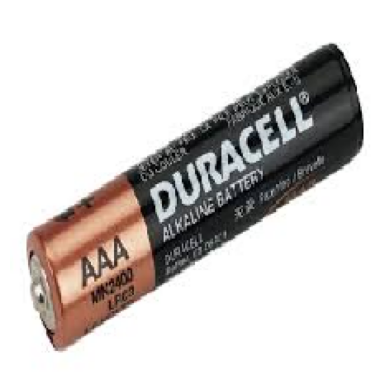

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Your waste material is battery with 93.23 % accuracy.


In [7]:
waste_prediction("uploads/battery.jpg")

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import time
import os  # Import the 'os' module

# Enable CUDA (if available)
# Check if CUDA is available
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available! Using GPU.")
    # Set memory growth to allow TensorFlow to allocate memory as needed
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("CUDA is not available. Using CPU.")

# Load the trained model
model = load_model("predictWaste12.h5")

# Define class labels
output_class = ["battery", "biological", "brown-glass", "cardboard", "clothes", "green-glass", "metal", "paper", "plastic", "shoes", "trash", "white-glass"]

# Define the color for the selection mask
selection_color = (255, 0, 0)  # Blue color for selection

def preprocess_frame(frame):
    """Preprocesses a single frame for prediction."""
    img_size = 224
    resized_frame = cv2.resize(frame, (img_size, img_size))
    img_array = np.expand_dims(resized_frame, axis=0)
    return img_array / 255.0

def predict_frame(frame):
    """Predicts the class of a preprocessed frame."""
    preprocessed_frame = preprocess_frame(frame)
    prediction = model.predict(preprocessed_frame)
    predicted_class_index = np.argmax(prediction)
    confidence = prediction[0][predicted_class_index]
    predicted_class = output_class[predicted_class_index]
    return predicted_class, confidence

def segment_objects(frame):
    """Segments multiple objects using a thresholding method, limiting to 3."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    objects = []
    # Sort contours by area in descending order and take the top 3
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]

    for contour in contours:
        if cv2.contourArea(contour) > 100:  # Minimum area to filter out small noise
            mask = np.zeros(frame.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            x, y, w, h = cv2.boundingRect(contour)
            objects.append((mask, contour, (x, y, w, h)))
    return objects

def apply_selection_mask(frame, mask, color):
    """Applies a color mask to the segmented region."""
    if mask is not None:
        color_mask = np.zeros_like(frame)
        color_mask[mask > 0] = color  # Apply color where the mask is white
        masked_frame = cv2.addWeighted(frame, 1, color_mask, 0.5, 0)  # Blend the mask with the original frame
        return masked_frame
    else:
        return frame

def classify_image(image_path, study_time=2, stability_threshold=0.8):
    """
    Performs garbage classification on a single image from a file.
    """
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not read image at {image_path}")
        return

    object_history = {}  # Store object predictions over time, keyed by object bounding box
    object_final_class = {} # Store the final decision for each object
    start_time = time.time()

    objects = segment_objects(frame)
    display_frame = frame.copy() # Create a copy for display purposes

    for mask, contour, (x, y, w, h) in objects:
        # Apply mask to the original frame to isolate the object
        masked_frame = apply_selection_mask(frame.copy(), mask, selection_color)

        # Crop the masked frame to the bounding box
        cropped_masked_frame = masked_frame[y:y+h, x:x+w]

        # Ensure the cropped frame is not empty before prediction
        if cropped_masked_frame.size > 0:
            predicted_class, confidence = predict_frame(cropped_masked_frame)

            # Bounding box and label
            cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box
            cv2.putText(display_frame, predicted_class, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            object_key = (x, y, w, h) # Use bounding box as key

            # Update object history
            if object_key not in object_history:
                object_history[object_key] = []
            object_history[object_key].append((predicted_class, confidence))

    elapsed_time = time.time() - start_time

    # Decision making process
    if elapsed_time >= study_time:
        for object_key, predictions in object_history.items():
            x, y, w, h = object_key
            class_counts = {}
            for obj_class, conf in predictions:
                class_counts[obj_class] = class_counts.get(obj_class, 0) + 1

            # Calculate the most frequent class and its stability
            most_frequent_class = max(class_counts, key=class_counts.get) if class_counts else "Unknown"
            stability = class_counts.get(most_frequent_class, 0) / len(predictions)

            # If the prediction is stable enough, make a final decision
            if stability >= stability_threshold:
                object_final_class[object_key] = most_frequent_class
                print(f"Final Decision for object at {object_key}: {most_frequent_class}")

        # Reset history, but keep final decisions
        object_history = {}
        start_time = time.time()

    # Display final decisions
    for object_key, final_class in object_final_class.items():
        x, y, w, h = object_key
        cv2.putText(display_frame, f"Final: {final_class}", (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow('Garbage Classification', display_frame)
    cv2.waitKey(0)  # Wait until a key is pressed
    cv2.destroyAllWindows()

# Example usage:
image_path = r"uploads/toy.jpg"  # Replace with the path to your image
classify_image(image_path, study_time=3, stability_threshold=0.7)

CUDA is not available. Using CPU.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import time
import os

# Enable CUDA (if available) - Same as before
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available! Using GPU.")
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("CUDA is not available. Using CPU.")

# Load the trained model - Same as before
model = load_model("predictWaste12.h5")

# Define class labels -  KEEP ORIGINAL LABELS FOR MODEL PREDICTION
output_class = ["battery", "biological", "brown-glass", "cardboard", "clothes", "green-glass", "metal", "paper", "plastic", "shoes", "trash", "white-glass"]

# --- NEW: Mapping Function ---
def map_to_biodegradability(original_class):
    """Maps the original class labels to 'Biodegradable' or 'Non-Biodegradable'."""
    biodegradable_classes = ["biological", "cardboard", "paper"]  # Add other biodegradable classes
    if original_class in biodegradable_classes:
        return "Biodegradable"
    else:
        return "Non-Biodegradable"

# Define the color for the selection mask - Same as before
selection_color = (255, 0, 0)  # Blue color for selection

def preprocess_frame(frame):
    """Preprocesses a single frame for prediction."""
    img_size = 224
    resized_frame = cv2.resize(frame, (img_size, img_size))
    img_array = np.expand_dims(resized_frame, axis=0)
    return img_array / 255.0

def predict_frame(frame):
    """Predicts the class of a preprocessed frame."""
    preprocessed_frame = preprocess_frame(frame)
    prediction = model.predict(preprocessed_frame)
    predicted_class_index = np.argmax(prediction)
    confidence = prediction[0][predicted_class_index]
    predicted_class = output_class[predicted_class_index]  # Use original class labels
    return predicted_class, confidence  # Return the ORIGINAL predicted class

def segment_object(frame):
    """Segments the largest object using a thresholding method."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    if contours:
        largest_contour = contours[0]
        if cv2.contourArea(largest_contour) > 100:
            mask = np.zeros(frame.shape[:2], dtype=np.uint8)
            cv2.drawContours(mask, [largest_contour], -1, 255, -1)
            x, y, w, h = cv2.boundingRect(largest_contour)
            return mask, largest_contour, (x, y, w, h)
    return None, None, None

def apply_selection_mask(frame, mask, color):
    """Applies a color mask to the segmented region."""
    if mask is not None:
        color_mask = np.zeros_like(frame)
        color_mask[mask > 0] = color
        masked_frame = cv2.addWeighted(frame, 1, color_mask, 0.5, 0)
        return masked_frame
    else:
        return frame

def classify_image(image_path, study_time=2, stability_threshold=0.8):
    """
    Performs garbage classification, maps to biodegradability, and displays results.
    """
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not read image at {image_path}")
        return

    object_history = {}
    object_final_class = {}
    start_time = time.time()

    mask, contour, (x, y, w, h) = segment_object(frame)
    display_frame = frame.copy()

    if mask is not None:
        masked_frame = apply_selection_mask(frame.copy(), mask, selection_color)
        cropped_masked_frame = masked_frame[y:y+h, x:x+w]

        if cropped_masked_frame.size > 0:
            predicted_class, confidence = predict_frame(cropped_masked_frame)  # Get original class
            biodegradability = map_to_biodegradability(predicted_class) # Map to biodegradability

            cv2.rectangle(display_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # Display the biodegradability label
            cv2.putText(display_frame, biodegradability, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            object_key = (x, y, w, h)

            if object_key not in object_history:
                object_history[object_key] = []
            # Store the biodegradability and confidence, NOT the original class
            object_history[object_key].append((biodegradability, confidence))

    elapsed_time = time.time() - start_time

    if elapsed_time >= study_time:
        for object_key, predictions in object_history.items():
            x, y, w, h = object_key
            class_counts = {}
            for obj_class, conf in predictions:  # obj_class is now biodegradability
                class_counts[obj_class] = class_counts.get(obj_class, 0) + 1

            most_frequent_class = max(class_counts, key=class_counts.get) if class_counts else "Unknown"
            stability = class_counts.get(most_frequent_class, 0) / len(predictions)

            if stability >= stability_threshold:
                object_final_class[object_key] = most_frequent_class  # Store biodegradability
                print(f"Final Decision for object at {object_key}: {most_frequent_class}")

        object_history = {}
        start_time = time.time()

    for object_key, final_class in object_final_class.items():
        x, y, w, h = object_key
        # Display the FINAL biodegradability decision
        cv2.putText(display_frame, f"Final: {final_class}", (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow('Garbage Classification', display_frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage (same as before, but now it shows biodegradability):
image_path = r"uploads/trash.jpeg"  # Use a valid image path
classify_image(image_path, study_time=3, stability_threshold=0.7)

CUDA is not available. Using CPU.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
